# OpenSCM Timeframes

In OpenSCM, the class for handling timeframes is `openscm.timesframes.Timeframe`.

In [1]:
from itertools import count
from copy import copy

import numpy as np
from matplotlib import pyplot as plt

from openscm import timeframes
from openscm.core import ParameterSet

In [2]:
COLOUR_1 = "lime"
COLOUR_2 = "midnightblue"
COLOUR_3 = "firebrick"
COLOUR_4 = "deeppink"

MARKER_1 = "o"
MARKER_2 = "^"
MARKER_3 = "+"
MARKER_4 = "x"

## Holding data

In OpenSCM, all data is stored in a `ParameterSet` instance. 

In [3]:
paras = ParameterSet()

---
## Period average data

As it stands, the only timeseries data which OpenSCM is equipped to handle is average data, that is data which represents the average value over a given time period. The most common example is emissions data, where each time point represents the average emissions flux for that time period e.g. 2100 emissions of 3 GtC / yr means that the average rate of emissions for 2100 was 3 GtC / yr.

<div class="alert alert-warning">
  <strong>Warning!</strong> Emissions data is ocassionally reported without the rate e.g. 2100 emissions were 3 GtC. In OpenSCM, we explicitly do not allow this as it doesn't actually make sense. The emissions were not 3 GtC at any given point in 2100, they were 3 GtC / yr for the whole year and hence the cumulative emissions for the year were 3 GtC. Before passing emissions data into OpenSCM it should have the units converted to rates (of course, cumulative emissions data should not be reported as rates and so perhaps the only fix required is changing the variable name from `Emissions` to `Cumulative Emissions`).
</div>

### Source data

To start with, we set our source data.

[TODO: add example of non-periodic data and explain the difference]

If your data is period, all we need to do to specify our timeseries is to provide the start time and period length of the time axis.

In [4]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_view = paras.get_writable_timeseries_view(
    ("Emissions", "CO2"),
    ("World",),
    "GtC / yr",
    start_time=0,
    period_length=10,
)
source_view.set_series(source_values)

[TODO: make this sane]

The `get_points` method of our view's `_timeframe_converter._source` allows us to get the timeseries for our data.

In [5]:
source_times = source_view._timeframe_converter._source.get_points(
    len(source_view.get_series())
)
source_times

array([ 0., 10., 20., 30., 40., 50., 60., 70.])

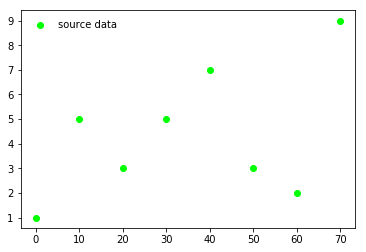

In [6]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.legend(frameon=False);

### Target data

Next we set our target, using one of OpenSCM's `ParameterView`'s.

In [35]:
target_view = paras.get_timeseries_view(
    ("Emissions", "CO2"),
    ("World",),
    "GtC / yr",
    start_time=4,
    period_length=7,
)
target_times = target_view._timeframe_converter._target.get_points(
    len(target_view.get_series())
)

### Conversion

To convert between different timeframes, assumptions always have to be made. At the moment, OpenSCM makes a few choices and assumptions. 


The first assumption is that the values in your timeseries represent the average value of the variable over a time period. This time period extends from the time time at which the value is provided, the 'data time', up until the 'data time' plus one time period. From here, interpolate the data such that their average (i.e. integral over the period divided by the period length) equals the original source data. [TODO: change this assumption as it's pretty convoluted?] We choose to interpolate based on three points per period. At each period edge the value is assumed to equal the average of the values for the two adjacent periods, at the period mid point the value is adjusted such that the period average equals the original period average (i.e. the original data value for that period). For the first and the last period the mid points are assumed to be at the period average and the outer edges are adjusted accordingly.

In a picture it looks like the below. To make it easier to see how the interpolation is integral preserving, we plot the source data with lines which show the integral, following the assumption that the data values represent the average over the time period.

[TODO: update in future]

In [12]:
def plot_timeframe(ax, values, timeframe, **kwargs):
    ax.step(timeframe.get_points(len(values) + 1), np.concatenate(([values[0]], values)), **kwargs)

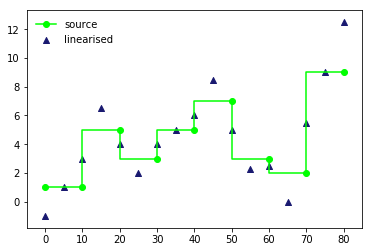

In [16]:
# TODO: make this sane(?)
linearised_points, linearised_values = timeframes._calc_linearization(
    source_view.get_series(), 
    source_view._timeframe_converter._source
)
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeframe_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    linearised_points, 
    linearised_values, 
    label="linearised", 
    marker=MARKER_2,
    color=COLOUR_2,
)
ax.legend(frameon=False);

In a second step, the linearized values are used to determine the values at the edges of the target timeseries (green dots in plot below) as well as at their sampling points (orange dots). This ensures that we retain as much information as possible. We use this information in the next step, when we determine the target timeseries values.

In [14]:
interpolation = timeframes._calc_interpolation_points(
    len(source_values),
    source_view._timeframe_converter._source,
    target_view._timeframe_converter._target
)
interpolation_values = np.interp(
    interpolation.points, linearised_points, linearised_values
)

#### Plot

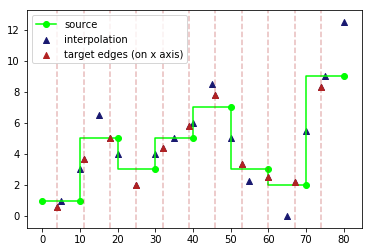

In [17]:
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeframe_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    interpolation.points, 
    interpolation_values, 
    label="interpolation", 
    marker=MARKER_2,
    color=COLOUR_2
)
ax.scatter(
    interpolation.points[interpolation.target_indices], 
    interpolation_values[interpolation.target_indices], 
    color=COLOUR_3, 
    marker=MARKER_2,
    zorder=10, 
    label="target edges (on x axis)"
)
for x in interpolation.points[interpolation.target_indices]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();

In a third step, we calculate the target timeframe values. We choose to integrate via the trapezium rule and then divide by the period length to get the target timeframe values.

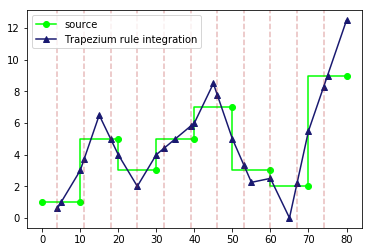

In [29]:
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeframe_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.plot(
    interpolation.points, 
    interpolation_values,
    label="Trapezium rule integration", 
    marker=MARKER_2,
    color=COLOUR_2
)
for x in interpolation.points[interpolation.target_indices]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();

In [30]:
interval_averages = timeframes._calc_interval_averages(
    interpolation,
    interpolation_values
)

#### Plot

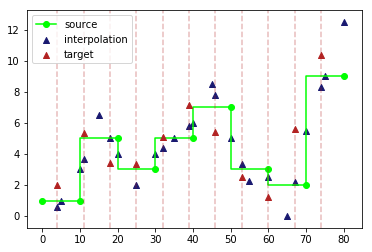

In [40]:
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeframe_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    interpolation.points, 
    interpolation_values, 
    label="interpolation", 
    marker=MARKER_2,
    color=COLOUR_2
)
ax.scatter(
    target_times, 
    interval_averages, 
    color=COLOUR_3, 
    marker=MARKER_2,
    zorder=10, 
    label="target"
)
for x in interpolation.points[interpolation.target_indices]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();

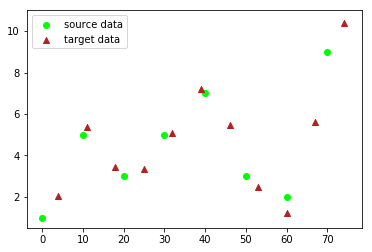

In [44]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    target_times, 
    interval_averages, 
    color=COLOUR_3, 
    marker=MARKER_2,
    zorder=10, 
    label="target data"
)
ax.legend();

### Using OpenSCM

Requesting the data from this view includes an automatic conversion onto our new timeseries.

In [42]:
target_view.get_series()

array([ 2.02142857,  5.37857143,  3.42857143,  3.34285714,  5.1       ,
        7.18571429,  5.44642857,  2.49642857,  1.20714286,  5.59285714,
       10.4       ])

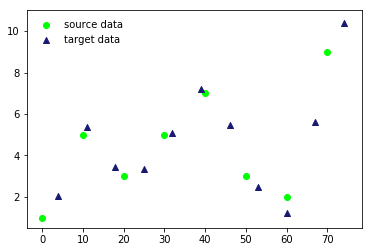

In [43]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    target_times, 
    target_view.get_series(), 
    label="target data", 
    marker=MARKER_2,
    color=COLOUR_2,
)
ax.legend(frameon=False);